In [37]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
import torch
import torch.nn as nn
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [38]:
tags=[]
inputs=[]
responses={}

with open('intents.json', 'r') as content:
    data=json.load(content)

In [39]:
print(data)

{'intents': [{'tag': 'Cuts', 'patterns': ['What to do if Cuts?', 'How to cure Cuts?', 'Which medicine to apply for Cuts?', 'what to apply on cuts?', 'Cuts'], 'responses': ['Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.'], 'context_set': ''}, {'tag': 'greeting', 'patterns': ['Hi', 'How are you', 'Is anyone there?', 'Hello', 'Whats up'], 'responses': ['Hi , i am your paramedic assistant'], 'context_set': ''}, {'tag': 'goodbye', 'patterns': ['cya', 'See you later', 'Goodbye', 'I am Leaving', 'Have a Good day', 'bye'], 'responses': ['Sad to see you go :(', 'Talk to you later', 'Goodbye!'], 'context_set': ''}, {'tag': 'Abrasions', 'patterns': ['how do you treat abrasions?', 'Do Abrasions cause scars?', 'Abrasions', 'what to do if abrasions?'

In [40]:
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for pattern in intent['patterns']:
        inputs.append(pattern)
        tags.append(intent['tag'])




In [41]:
df=pd.DataFrame({"Pattern":inputs, "Tags": tags})
df.head(10)

,Pattern,Tags
0,What to do if Cuts?,Cuts
1,How to cure Cuts?,Cuts
2,Which medicine to apply for Cuts?,Cuts
3,what to apply on cuts?,Cuts
4,Cuts,Cuts
5,Hi,greeting
6,How are you,greeting
7,Is anyone there?,greeting
8,Hello,greeting
9,Whats up,greeting


In [42]:
output_dim=len(df['Tags'].unique())
print(output_dim)

46


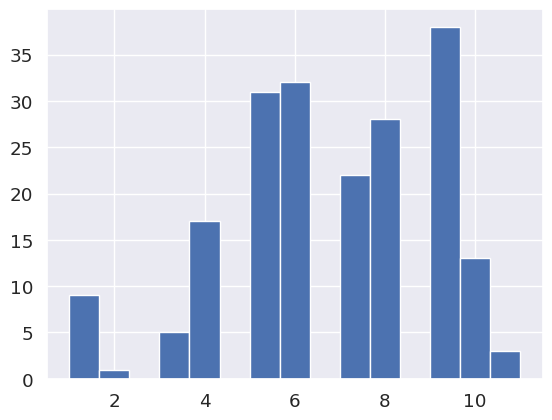

In [43]:
seq_len = [len(i.split()) for i in df['Pattern']]
pd.Series(seq_len).hist(bins = 15)
max_seq_len=10

/tmp/ipykernel_3387/3671009547.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


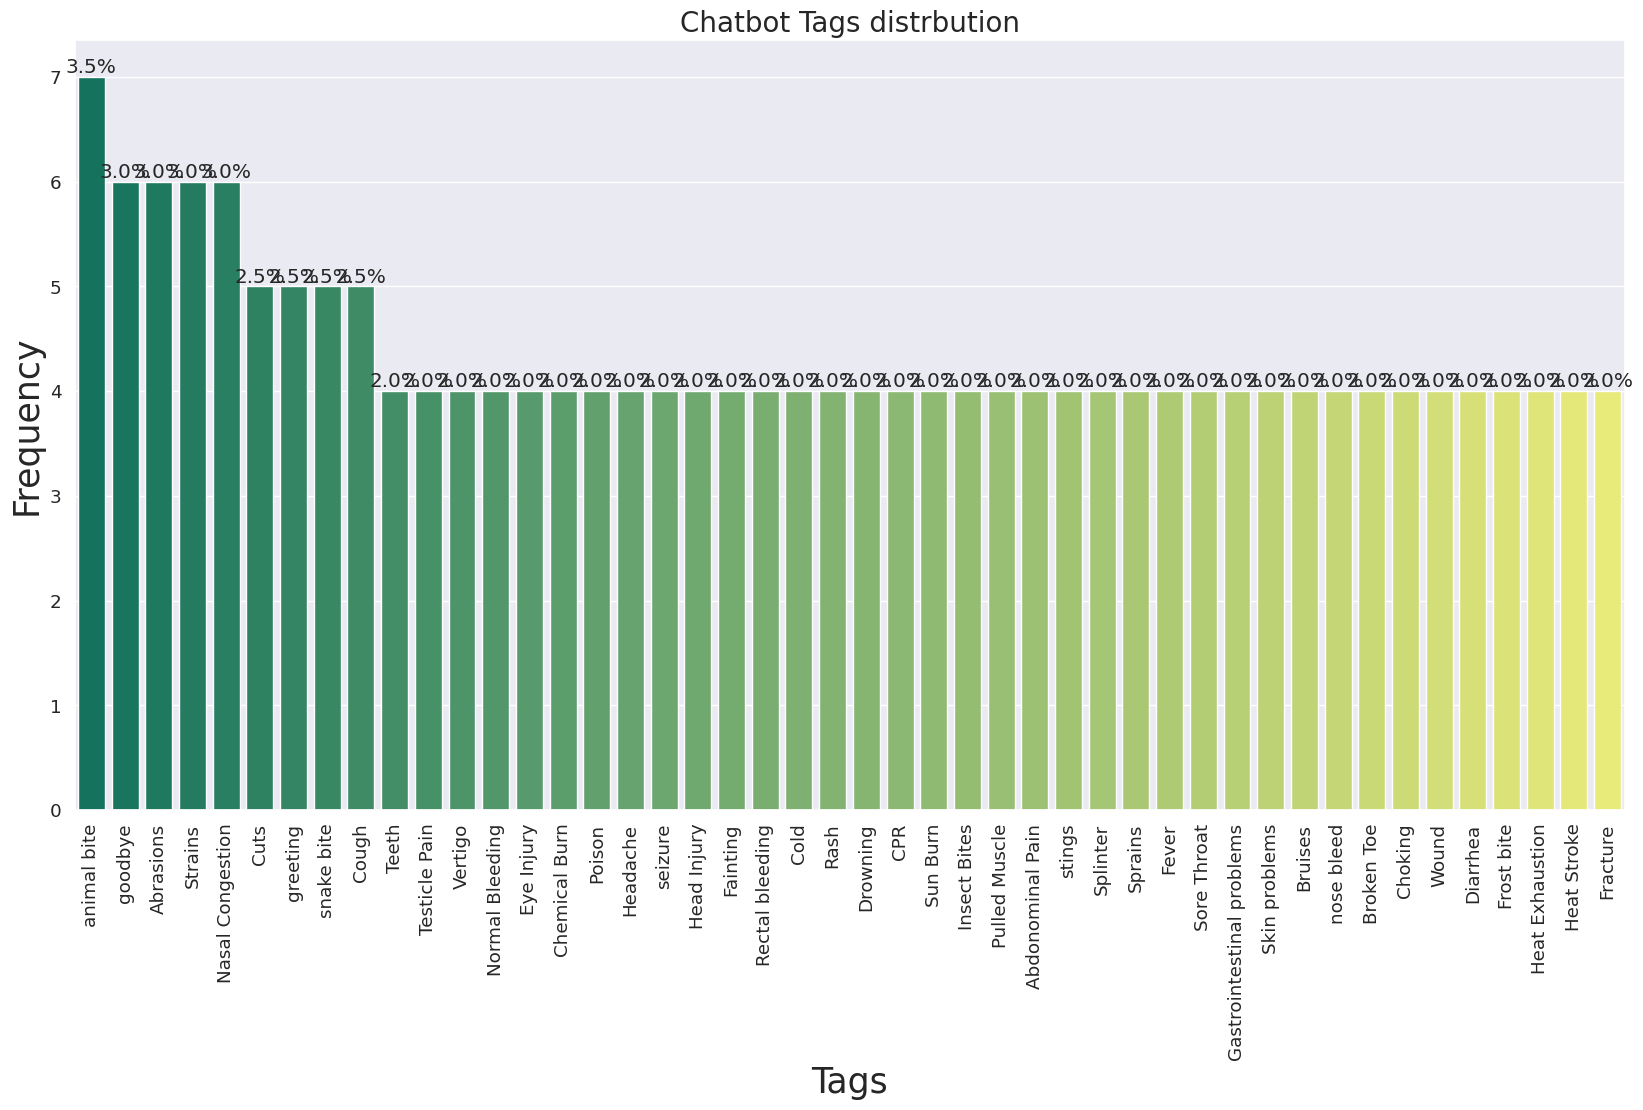

In [44]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()



    sns.set(font_scale = 1.2)
order = df['Tags'].value_counts().index
count_plot(df['Tags'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [45]:
train_text, train_labels = df['Pattern'], df['Tags']


In [46]:
model_name='distilbert-base-uncased'
tokenizer=DistilBertTokenizer.from_pretrained(model_name)
bert=DistilBertModel.from_pretrained(model_name)

In [47]:
tokens_train=tokenizer(
    train_text.to_list(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/syed227/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [48]:
tokens_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [49]:
tokens_train.get('input_ids')

[[101, 2054, 2000, 2079, 2065, 7659, 1029, 102, 0, 0],
 [101, 2129, 2000, 9526, 7659, 1029, 102, 0, 0, 0],
 [101, 2029, 4200, 2000, 6611, 2005, 7659, 1029, 102, 0],
 [101, 2054, 2000, 6611, 2006, 7659, 1029, 102, 0, 0],
 [101, 7659, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 7632, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2129, 2024, 2017, 102, 0, 0, 0, 0, 0],
 [101, 2003, 3087, 2045, 1029, 102, 0, 0, 0, 0],
 [101, 7592, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2054, 2015, 2039, 102, 0, 0, 0, 0, 0],
 [101, 22330, 2050, 102, 0, 0, 0, 0, 0, 0],
 [101, 2156, 2017, 2101, 102, 0, 0, 0, 0, 0],
 [101, 9119, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 1045, 2572, 2975, 102, 0, 0, 0, 0, 0],
 [101, 2031, 1037, 2204, 2154, 102, 0, 0, 0, 0],
 [101, 9061, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2129, 2079, 2017, 7438, 11113, 8180, 8496, 1029, 102],
 [101, 2079, 11113, 8180, 8496, 3426, 13521, 1029, 102, 0],
 [101, 11113, 8180, 8496, 102, 0, 0, 0, 0, 0],
 [101, 2054, 2000, 2079, 2065, 11113, 8180, 8496, 1029, 102],
 [101, 2029, 4200, 2000

In [50]:
tokens_train.get('attention_mask')

[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1,

In [51]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask=torch.tensor(tokens_train['attention_mask'])

In [52]:
le=LabelEncoder()
train_labels=le.fit_transform(train_labels)


In [53]:
train_y=torch.tensor(train_labels.tolist())

In [54]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size=16
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [55]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert=bert
        self.dropout=nn.Dropout(0.2)

        self.relu=nn.ReLU()

        self.fc1=nn.Linear(768, 512)
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256,output_dim)

        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs=self.bert(sent_id, attention_mask=mask)[0][:,0]
        x=self.fc1(cls_hs)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc2(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc3(x)

        x=self.softmax(x)

        return x



In [56]:
for param in bert.parameters():
      param.requires_grad = False
model = BERT(bert)

summary(model)

Layer (type:depth-idx)                                  Param #
BERT                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           11,822
├─LogSoftmax: 1-7                                       --
Total

In [57]:
optimizer = AdamW(model.parameters(), lr = 1e-3)

/home/syed227/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [58]:
class_wts = compute_class_weight(class_weight='balanced',classes= np.unique(train_labels), y=train_labels)
print(class_wts)

[1.08152174 0.72101449 1.08152174 1.08152174 1.08152174 1.08152174
 1.08152174 1.08152174 0.86521739 0.86521739 1.08152174 1.08152174
 1.08152174 1.08152174 1.08152174 1.08152174 1.08152174 1.08152174
 1.08152174 1.08152174 1.08152174 1.08152174 1.08152174 0.72101449
 1.08152174 1.08152174 1.08152174 1.08152174 1.08152174 1.08152174
 1.08152174 1.08152174 1.08152174 0.72101449 1.08152174 1.08152174
 1.08152174 1.08152174 1.08152174 0.61801242 0.72101449 0.86521739
 1.08152174 1.08152174 0.86521739 1.08152174]


In [59]:
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [64]:
train_losses=[]
# number of training epochs
epochs = 400

In [65]:
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [66]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 400



 Epoch 2 / 400

 Epoch 3 / 400

 Epoch 4 / 400

 Epoch 5 / 400

 Epoch 6 / 400

 Epoch 7 / 400

 Epoch 8 / 400

 Epoch 9 / 400

 Epoch 10 / 400

 Epoch 11 / 400

 Epoch 12 / 400

 Epoch 13 / 400

 Epoch 14 / 400

 Epoch 15 / 400

 Epoch 16 / 400

 Epoch 17 / 400

 Epoch 18 / 400

 Epoch 19 / 400

 Epoch 20 / 400

 Epoch 21 / 400

 Epoch 22 / 400

 Epoch 23 / 400

 Epoch 24 / 400

 Epoch 25 / 400

 Epoch 26 / 400

 Epoch 27 / 400

 Epoch 28 / 400

 Epoch 29 / 400

 Epoch 30 / 400

 Epoch 31 / 400

 Epoch 32 / 400

 Epoch 33 / 400

 Epoch 34 / 400

 Epoch 35 / 400

 Epoch 36 / 400

 Epoch 37 / 400

 Epoch 38 / 400

 Epoch 39 / 400

 Epoch 40 / 400

 Epoch 41 / 400

 Epoch 42 / 400

 Epoch 43 / 400

 Epoch 44 / 400

 Epoch 45 / 400

 Epoch 46 / 400

 Epoch 47 / 400

 Epoch 48 / 400

 Epoch 49 / 400

 Epoch 50 / 400

 Epoch 51 / 400

 Epoch 52 / 400

 Epoch 53 / 400

 Epoch 54 / 400

 Epoch 55 / 400

 Epoch 56 / 400

 Epoch 57 / 400

 Epoch 58 / 400

 Epoch 59 / 400

 Epoch 60 / 400

 Epo

In [67]:
def get_prediction(str):
    test_text = [str]
    model.eval()
 
    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    
    preds = None
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
    
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    print("Intent Identified: ", le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]


def get_response(message): 
    intent = get_prediction(message)
    for i in data['intents']: 
        if i["tag"] == intent:
            result = random.choice(i["responses"])
            break
    print(f"Response : {result}")
    return "Intent: "+ intent + '\n' + "Response: " + result

In [74]:
get_response("i have a cut")

Intent Identified:  Broken Toe
Response : 1)To help decrease pain and swelling in a broken toe, elevate the foot, ice the injury, and stay off the foot. 2)Depending on the severity of the fracture, the toe may need to be put back into place (reduced), and some compound toe fractures may require surgery.3) Most broken toes heal without complications in six weeks.


'Intent: Broken Toe\nResponse: 1)To help decrease pain and swelling in a broken toe, elevate the foot, ice the injury, and stay off the foot. 2)Depending on the severity of the fracture, the toe may need to be put back into place (reduced), and some compound toe fractures may require surgery.3) Most broken toes heal without complications in six weeks.'